# Continuum plots

Loads depth-frequency-time PSD data and then plots continuum for various analyses.

## Imports
Necessary modules for analysis.

In [50]:
# import modules

import xarray as xr
import datetime as dt
import cmocean
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import pandas as pd
import matplotlib.dates as pldates
import matplotlib.colors as colors
from scipy.stats import chi2
from scipy.optimize import curve_fit
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013

ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds[0].attrs)
#rint(ds[0].Sxxu_d)

In [3]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')     # get GM data from separate code
gm_freq = np.asarray(gm[176:246,0])/(2*np.pi)       # GM frequency range (7e-5 to 1.2e-4)
gm_psd = np.asarray(gm[176:246,1])*(np.pi)          # 1/2 GM amplitudes
gmpw = gm_psd * (gm_freq**2)                        # whiten
gmp_avg = np.nanmean(gmpw)                          # GM 'c' value.
print('1/2 GM amplitude:',gmp_avg)

1/2 GM amplitude: 8.068588316559413e-09


## Continuum fits (a, b)

In [ ]:
# select time range

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

didx = -29                   # -1 for lower depth, -20 for mid-depth

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect_c.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect_c[j].values)
            phi_u_temp.append(ds[i].Sxxu_c[didx,:,j])  #.rolling(specf_c=10,center=True).mean().dropna('specf_c'))                 # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv_c[didx,:,j])  #.rolling(specf_c=10,center=True).mean().dropna('specf_c'))
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

d_stamp = ds[0].depth[didx].values
print('Depth:',-d_stamp,'m')

In [ ]:
# WKB scale and select depth

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale[didx].values)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale[didx].values)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)
    
if adcp == 'Slope':
    didx = didx           # -1 for lower depth, -20 for mid-depth
elif adcp == 'Axis75':
    didx = didx           # -1 for lower depth, -19 for mid-depth
elif adcp == 'Axis55':
    didx = didx           # -1 for lower depth, -8 for mid-depth

u,v,time = [],[],[]
for i in range(n_seg):
    u_test,v_test,time_test = [],[],[]
    for j in range(len(WKB_u[i])):
        u_test.append(WKB_u[i][j]) 
        v_test.append(WKB_v[i][j])
        time_test.append(WKB_u[i][j].spect_c.values)
    u.append(u_test)
    v.append(v_test)
    time.append(time_test)

In [ ]:
# continuum fits (6e-5 to 1e-4 Hz)

lowf = 15                    # set frequency range for continuum
highf = 28

frequencies = u[0][0].specf_c.values
f_range = frequencies[lowf:highf]      # set data range for continuum

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

ua,ub,va,vb = [],[],[],[]
u_c,v_c = [],[]

for i in range(n_seg):
    ua_temp,ub_temp,va_temp,vb_temp = [],[],[],[]
    u_range,v_range = [],[]
    for j in range(len(u[i])):
        u_range_temp = u[i][j][lowf:highf].values
        v_range_temp = v[i][j][lowf:highf].values
        # Fit the power-law data
        upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range_temp, p0=[1e-8, -2], bounds=([1e-10,-4],[1e-6,0]),maxfev=1000)
        vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range_temp, p0=[1e-8, -2], bounds=([1e-10,-4],[1e-6,0]),maxfev=1000)

        # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
        #ustdevs = np.sqrt(np.diag(ucov))
        #vstdevs = np.sqrt(np.diag(vcov))

        # Calculate the residuals
        #ures = u_range - power_law(f_range, *upars)
        #vres = v_range - power_law(f_range, *vpars)
        
        ua_temp.append(upars[0])       # get a and b coefficients
        ub_temp.append(upars[1])
        va_temp.append(vpars[0])
        vb_temp.append(vpars[1])
        u_range.append(u_range_temp)
        v_range.append(v_range_temp)
    
    ua.append(ua_temp)       # get a and b coefficients
    ub.append(ub_temp)
    va.append(va_temp)
    vb.append(vb_temp)
    u_c.append(u_range)
    v_c.append(v_range)

In [ ]:
# average a and b data

n_avg = 15
dua_roll_ua,dub_roll_ub,dva_roll_va,dvb_roll_vb = [],[],[],[]
for i in range(n_seg):
    dua = xr.Dataset(
            data_vars=dict(
                ua = (['time'],ua[i]),
                ub = (['time'],ub[i]),
                va = (['time'],va[i]),
                vb = (['time'],vb[i]),
            ),
            coords=dict(
                time = time[i],
            ))
    if len(time[i]) < n_avg:
        continue
    elif len(dua.time) >= n_avg:
        dua_roll_time_ua = dua.ua.coarsen(time=n_avg,boundary='trim').mean() #.dropna('time')
        dub_roll_time_ub = dua.ub.coarsen(time=n_avg,boundary='trim').mean() #.dropna('time')
        dva_roll_time_va = dua.va.coarsen(time=n_avg,boundary='trim').mean() #.dropna('time')
        dvb_roll_time_vb = dua.vb.coarsen(time=n_avg,boundary='trim').mean() #.dropna('time')
    dua_roll_ua.append(dua_roll_time_ua)
    dub_roll_ub.append(dub_roll_time_ub)
    dva_roll_va.append(dva_roll_time_va)
    dvb_roll_vb.append(dvb_roll_time_vb)

In [ ]:
#fig,ax=plt.subplots(1,1)
#ax.loglog(frequencies,u[0][1])
#ax.set_ylim(1e-3,1e3)

In [ ]:
# plot a values

fig,ax = plt.subplots(1,1,figsize=(12,4.8))

ax.set_title(fr'Power law ($af^b$) amplitudes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$a$',fontsize=14)  # (m/s)^2 ???
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ua[i],label='Cross-slope',color='tab:blue')
            #ax.plot(time[i],va[i],label='Along-slope',color='tab:orange')
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],label='Cross-slope',color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],label='Cross-canyon',color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ua[i],color='tab:blue')
            #ax.plot(time[i],va[i],color='tab:orange')
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],color='tab:orange')

ax.set_yscale('log')
ax.set_xlim(start_date,end_date)
#ax.set_ylim(1e-14,5e0)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='best',frameon=False)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_a_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# plot b values

fig,ax = plt.subplots(1,1,figsize=(12,4.8))

ax.set_title(fr'Power law ($af^b$) slopes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$b$',fontsize=14)
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ub[i],label='Cross-slope',color='tab:blue')
            #ax.plot(time[i],vb[i],label='Along-slope',color='tab:orange')
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],label='Cross-slope',color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            #ax.plot(time[i],ub[i],label='Cross-canyon',color='tab:blue')
            #ax.plot(time[i],vb[i],label='Along-canyon',color='tab:orange')
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],label='Cross-canyon',color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ub[i],color='tab:blue')
            #ax.plot(time[i],vb[i],color='tab:orange')
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],color='tab:orange')
            
ax.set_xlim(start_date,end_date)
ax.set_ylim(-3.5,0)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='best',frameon=False)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_b_{adcp}_{t_stamp}.pdf',format='pdf')

## Get c amplitudes vs GM

In [4]:
# revise plotting variables

frequencies = ds[0].specf_s.values
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

In [5]:
# select time range

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect_s.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect_s[j].values)
            phi_u_temp.append(ds[i].Sxxu_d[:,:,j])                   # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv_d[:,:,j])
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

Output time range: 2013-01-03T16:07:30.000000000 to 2013-12-27T00:07:30.000000000


In [6]:
# WKB scale

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)

In [7]:
# loop through depth    

# specify continuum range

lowf = 32                    # set frequency range for continuum
highf = 56

f_range = frequencies[lowf:highf]      # set data range for continuum

u_ts,v_ts,time = [],[],[]
for d in range(len(depth)):

    u,v,time_t = [],[],[]
    for i in range(n_seg):
        u_test,v_test,time_test = [],[],[]
        for j in range(len(phi_u[i])):
            u_test.append(WKB_u[i][j][d,:].values)        
            v_test.append(WKB_v[i][j][d,:].values)
            time_test.append(WKB_u[i][j].spect_s.values)
        u.append(u_test)
        v.append(v_test)
        time_t.append(time_test)

    u_c,v_c = [],[]

    for i in range(n_seg):
        u_range,v_range = [],[]
        for j in range(len(u[i])):
            u_range_temp = u[i][j][lowf:highf]
            v_range_temp = v[i][j][lowf:highf]
            u_range.append(u_range_temp)
            v_range.append(v_range_temp) 
        u_c.append(u_range)
        v_c.append(v_range)

    # whiten and take average

    u_c_avg, v_c_avg = [],[]
    for i in range(n_seg):
        u_c_w_t,v_c_w_t = [],[]
        for j in range(len(u_c[i])):
            uw = u_c[i][j] * (f_range**2)
            vw = v_c[i][j] * (f_range**2)
            u_c_w_t.append(np.nanmean(uw))
            v_c_w_t.append(np.nanmean(vw))
        u_c_avg.append(u_c_w_t)
        v_c_avg.append(v_c_w_t)
        
    u_ts.append(u_c_avg)
    v_ts.append(v_c_avg)
    time.append(time_t)
    
# depth, n_seg, time
print('Freq. range:',f_range[0],'to',f_range[-1],'Hz')

<ipython-input-7-7d0eaa1e76cf>:44: RuntimeWarning: Mean of empty slice
  u_c_w_t.append(np.nanmean(uw))
<ipython-input-7-7d0eaa1e76cf>:45: RuntimeWarning: Mean of empty slice
  v_c_w_t.append(np.nanmean(vw))


Freq. range: 6.944375e-05 to 0.00011935644531250001 Hz


In [8]:
# reorganise for n_seg,depth,time

uts,vts,ts = [],[],[]
for i in range(n_seg):
    uts_temp,vts_temp,ts_temp = [],[],[]
    for d in range(len(depth)):
        uts_temp.append(u_ts[d][i])
        vts_temp.append(v_ts[d][i])
        ts_temp.append(time[d][i])
    uts.append(uts_temp)
    vts.append(vts_temp)
    ts.append(ts_temp[0])

In [9]:
# get GM comparison

uGM,vGM = [],[]
for i in range(n_seg):
    uGM.append(uts[i]/gmp_avg)
    vGM.append(vts[i]/gmp_avg)

<IPython.core.display.Javascript object>


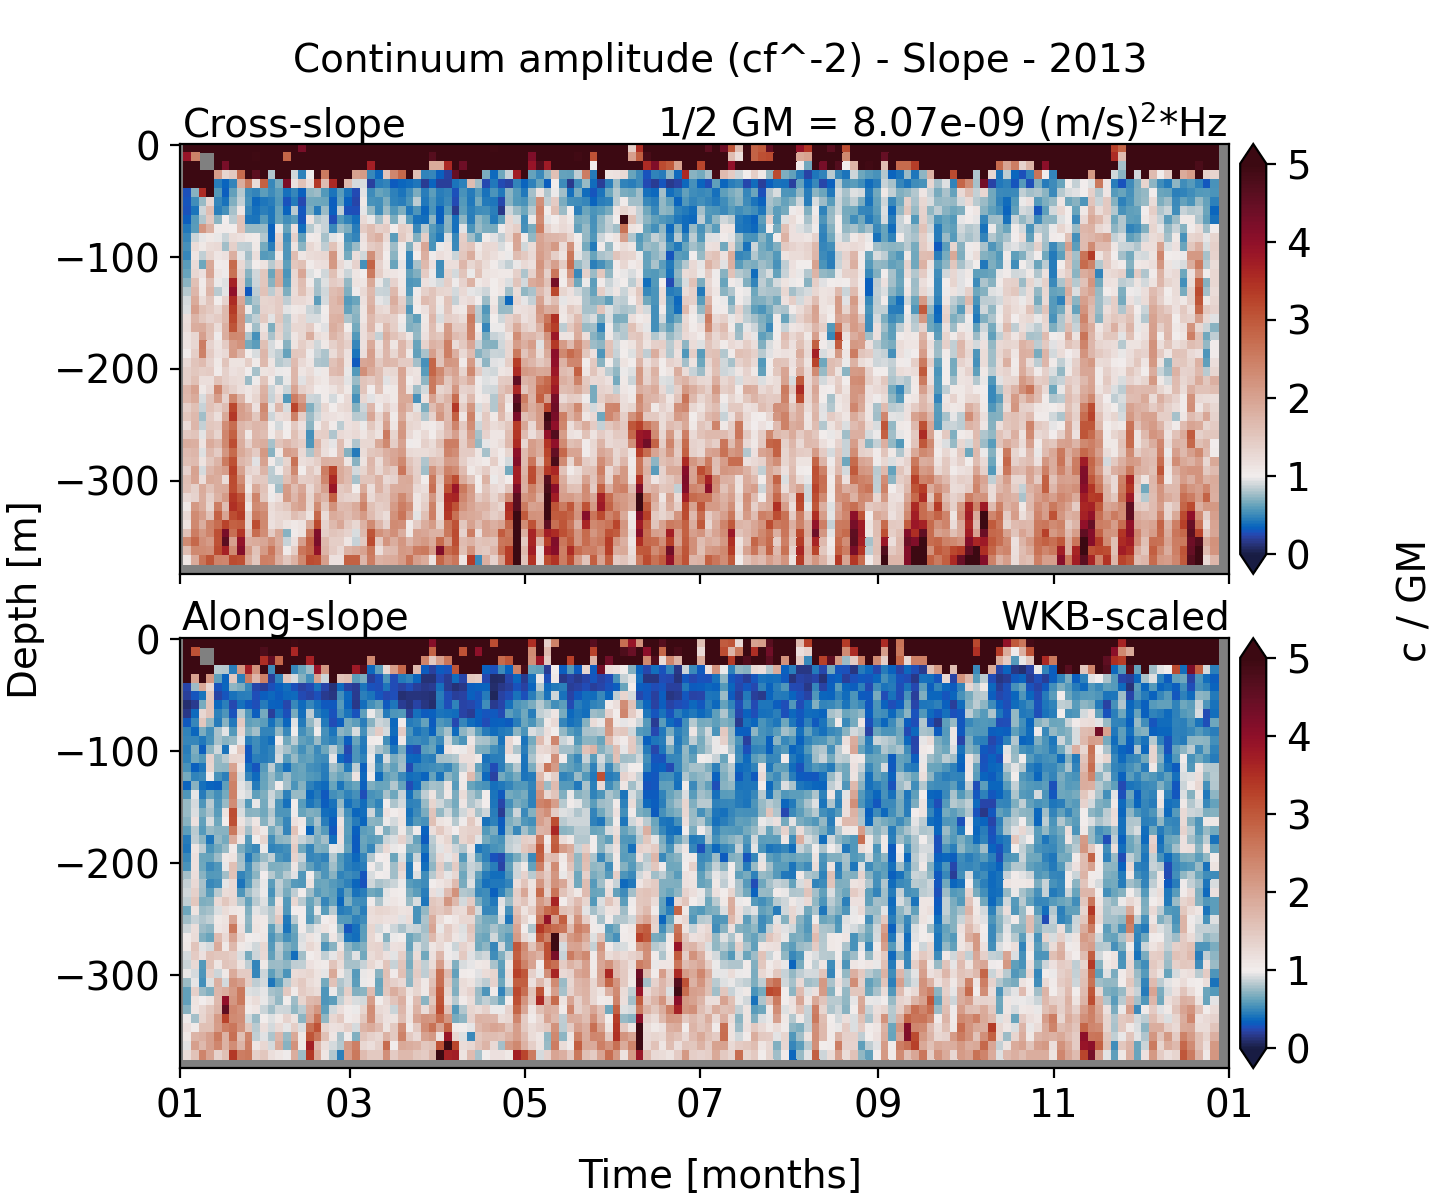

In [10]:
# plot c/GM ratio

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Continuum amplitude (cf^-2) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'c / GM', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.695,0.475, 'WKB-scaled',fontsize=14)
fig.text(0.456,0.886, fr'1/2 GM = {gmp_avg:1.2e} (m/s)$^2$*Hz',fontsize=14)

if adcp == 'Slope':
    vmin = 0
    vmax = 5
    fig.text(0.205, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.205, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 0
    vmax = 7
    fig.text(0.215, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.215, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 0
    vmax = 7
    fig.text(0.215, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.215, 0.475, 'Along-canyon', ha='center',fontsize=14)

norm = colors.TwoSlopeNorm(vmin=vmin,vcenter=1,vmax=vmax)
for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, uGM[i], rasterized=True,cmap='cmo.balance',norm=norm,shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, vGM[i], rasterized=True,cmap='cmo.balance',norm=norm,shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_cGM_{adcp}_{t_stamp}.pdf',format='pdf')

## Dissipation estimates

In [11]:
# dissipation (Althaus et al., 2003)

eps0 = 4.1e-11           # [W/kg]
N0 = 5.24e-3             # GM reference buoyancy [rad/s]
N = 2.53e-3              # local WKB reference buoyancy [rad/s]
cor = 1.09e-4            # local Coriolis parameter [rad/s]
wM2 = 1.41e-4            # semidiurnal frequency [rad/s]
Rw = 2.13                # cannonical depth-average semidiurnal shear/strain ratio (Kunze et al., 2002)

fRw = (((Rw + 1) / Rw)**2) * ( np.arccosh(N / cor) + ((25 * np.arccos(cor / N)) / np.sqrt(Rw)))   # dimensionless upper bound

eps_u,eps_v,eps_tot = [],[],[]
for i in range(n_seg):
    eps_u_temp = eps0 * ((N**2) / (N0**2)) * (uGM[i]**2) * fRw       # dissipation rates [W / kg]
    eps_u.append(eps_u_temp)
    eps_v_temp = eps0 * ((N**2) / (N0**2)) * (vGM[i]**2) * fRw       # dissipation rates [W / kg]
    eps_v.append(eps_v_temp)
    eps_tot_temp = (eps_u_temp/2)+(eps_v_temp/2)
    eps_tot.append(eps_tot_temp)

<IPython.core.display.Javascript object>


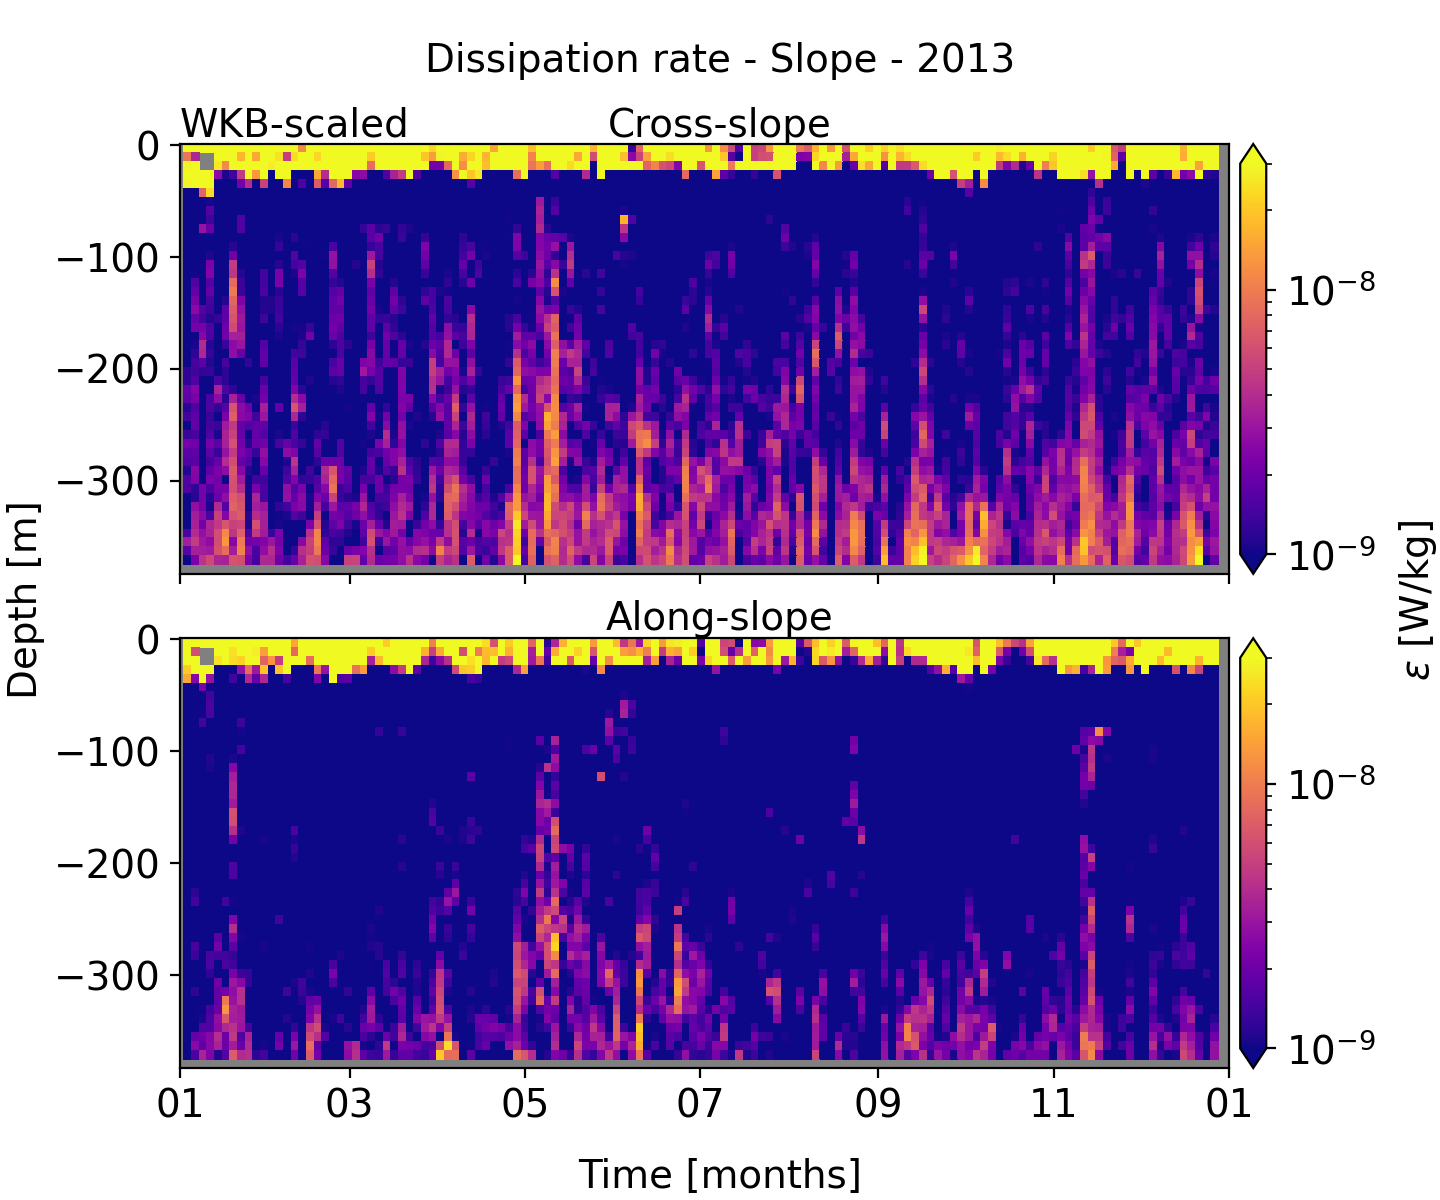

In [13]:
# plot dissipation estimates

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Dissipation rate - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'$\epsilon$ [W/kg]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, eps_u[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, eps_v[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_diss_{adcp}_{t_stamp}.pdf',format='pdf')

## Turbulent eddy diffusivities

In [14]:
# diffusivities (Kunze et al., 2002)

gamma = 0.2       # canonical mixing efficiency
N2 = N**2

kappa_u, kappa_v , kappa_tot = [],[],[]
for i in range(n_seg):
    kappa_u_temp = (gamma * eps_u[i]) / N2
    kappa_u.append(kappa_u_temp)
    kappa_v_temp = (gamma * eps_v[i]) / N2
    kappa_v.append(kappa_v_temp)
    kappa_tot_temp = (kappa_u_temp/2)+(kappa_v_temp/2)
    kappa_tot.append(kappa_tot_temp)

<IPython.core.display.Javascript object>


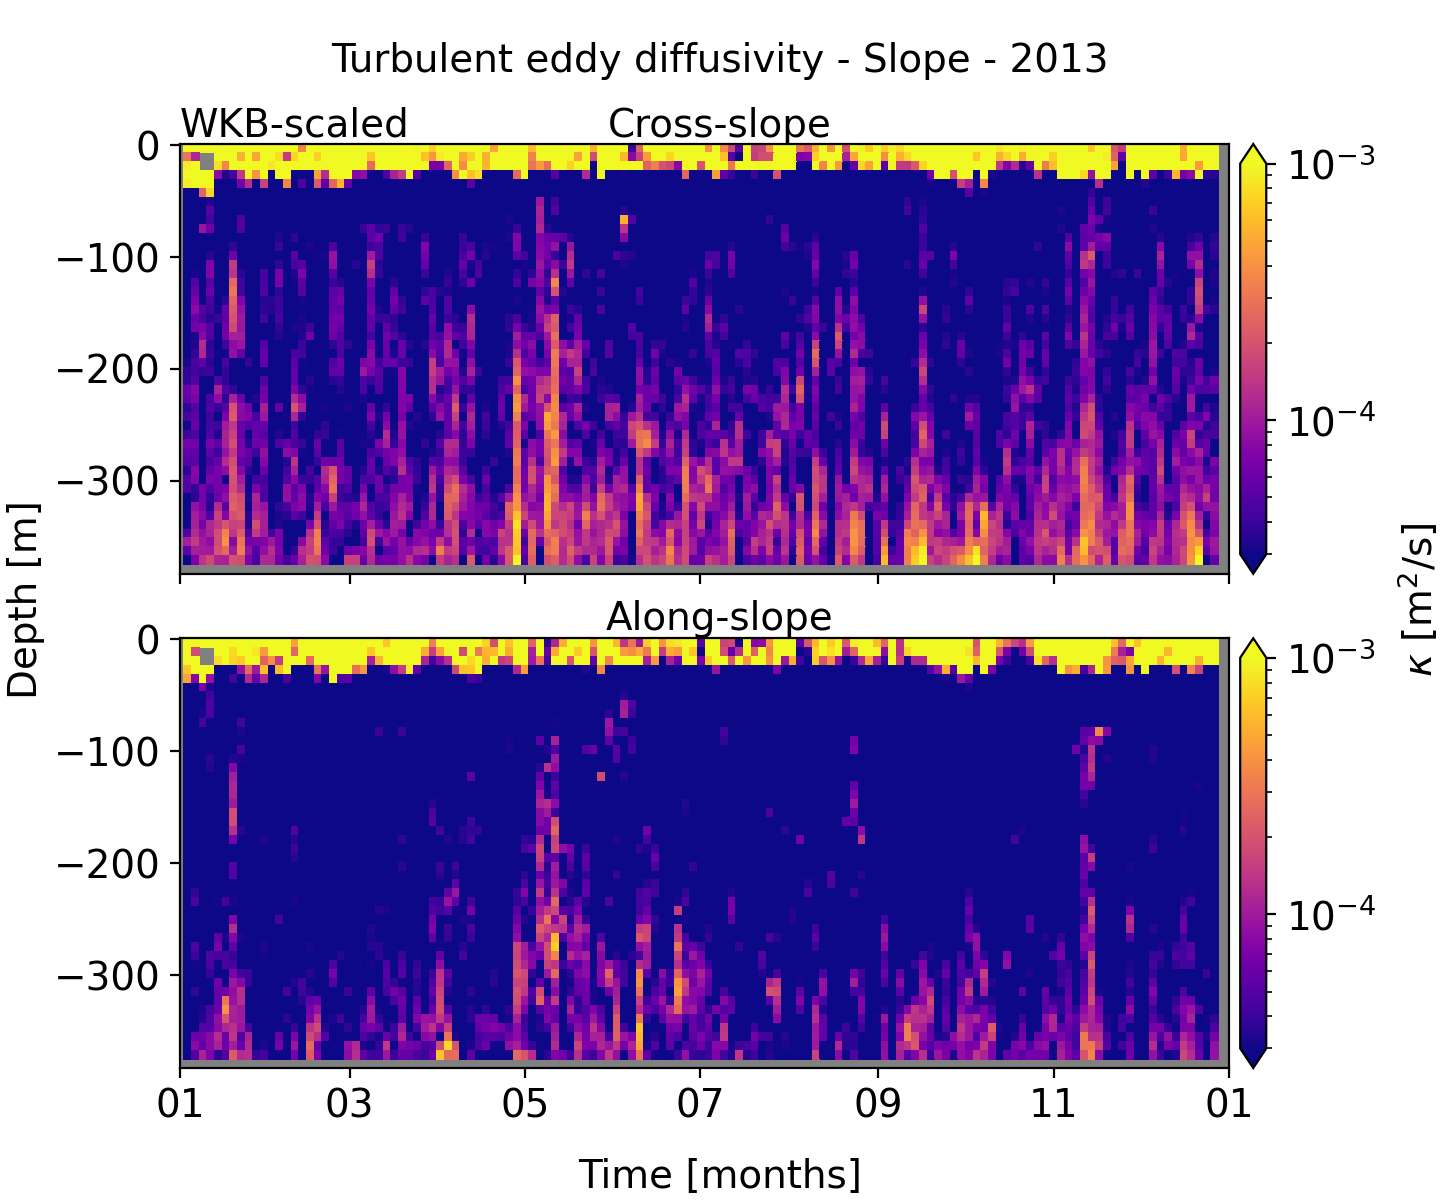

In [15]:
# plot diffusivities

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Turbulent eddy diffusivity - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'$\kappa$ [m$^2$/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 3e-5
    vmax = 1e-3
    fig.text(0.5, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 4e-5
    vmax = 8e-4
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 4e-5
    vmax = 8e-4
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, kappa_u[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, kappa_v[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_diff_{adcp}_{t_stamp}.pdf',format='pdf')

## Total plots

<IPython.core.display.Javascript object>


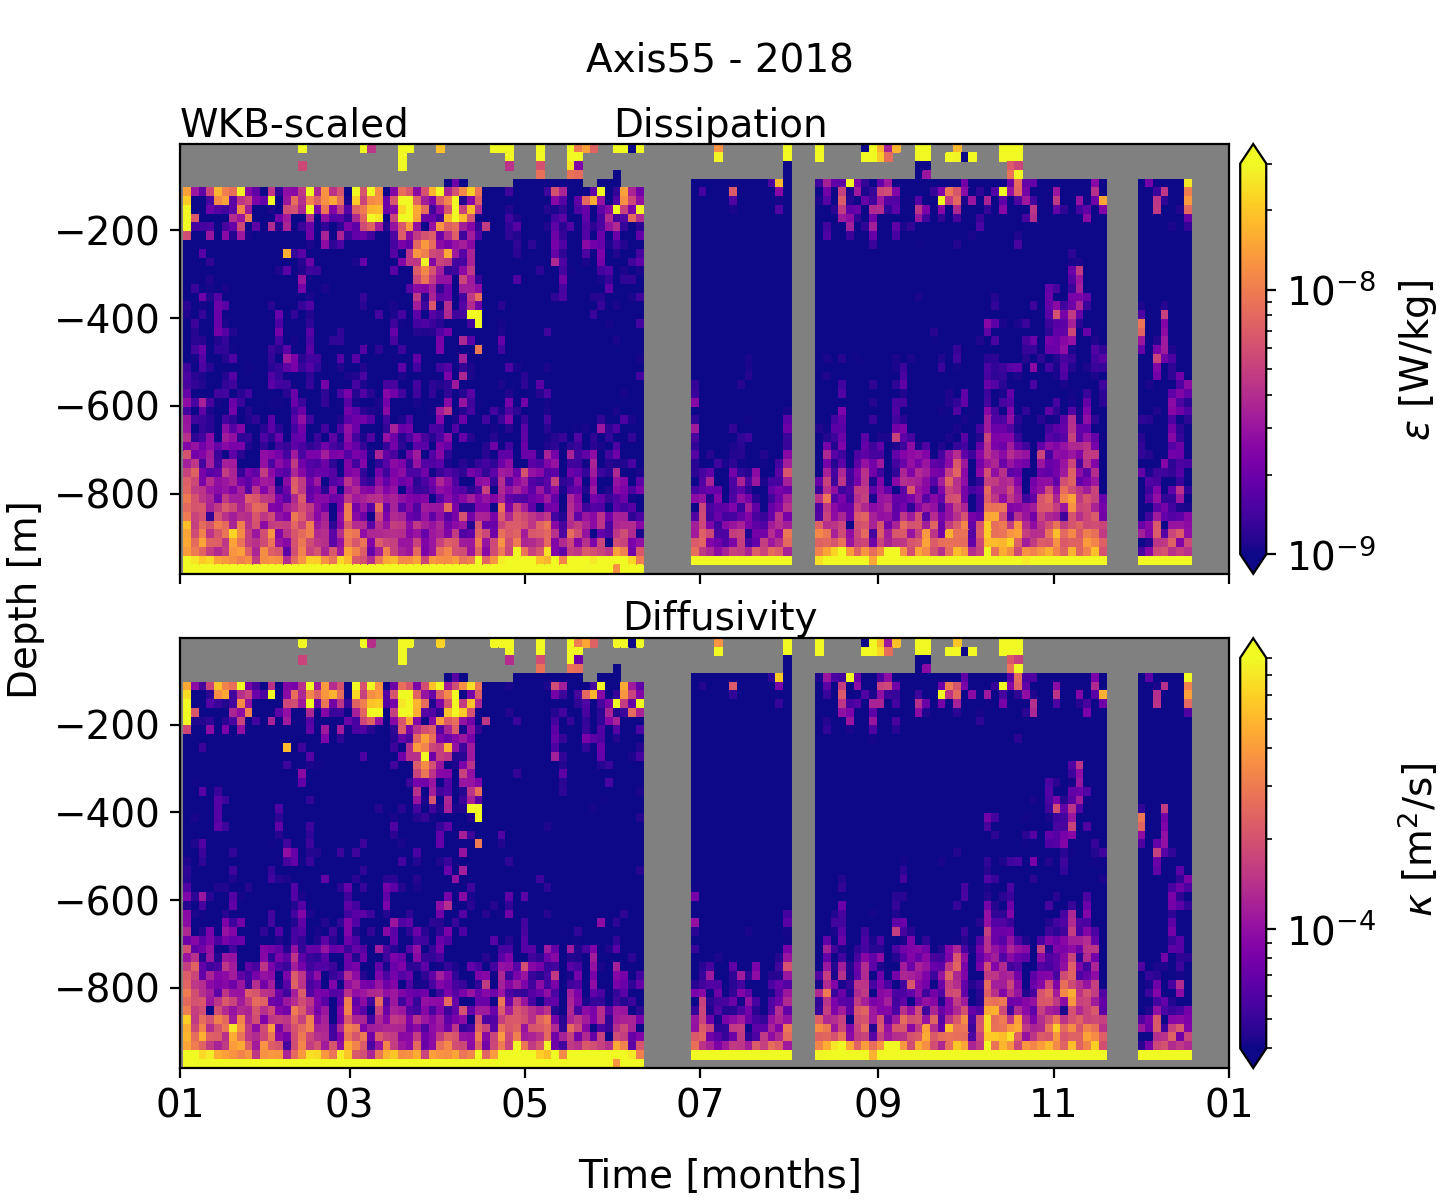

In [161]:
# plot diffusivities and dissipation

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.3, r'$\kappa$ [m$^2$/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.7, r'$\epsilon$ [W/kg]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 1e-9
    vmax = 2e-8
    vmin1 = 2e-5
    vmax1 = 8e-4
    fig.text(0.5, 0.886, 'Dissipation', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Diffusivity', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 1e-9
    vmax = 4e-8
    vmin1 = 4e-5
    vmax1 = 8e-4
    fig.text(0.5, 0.886, 'Dissipation', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Diffusivity', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 1e-9
    vmax = 3e-8
    vmin1 = 4e-5
    vmax1 = 8e-4
    fig.text(0.5, 0.886, 'Dissipation', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Diffusivity', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, eps_tot[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, kappa_tot[i], rasterized=True,norm=colors.LogNorm(vmin=vmin1, vmax=vmax1),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_tot_{adcp}_{t_stamp}.pdf',format='pdf')

## Seasonality comparisons

In [95]:
# import data

f_name = 'Continuum'
site = 'Axis'     # Slope or Axis
band2 = 'Semidiurnal'

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_3.nc'))

depth = ds_2013[0].depth.values    
    
ds2_2013,ds2_2014,ds2_2017,ds2_2018 = [],[],[],[]
if site == 'Slope':
    ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2013_0.nc'))
    ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2014_0.nc'))
    ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2017_0.nc'))
    ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2017_1.nc'))
    ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2013_0.nc'))
    ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2013_1.nc'))
    ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_0.nc'))
    ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_1.nc'))
    ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_2.nc'))
    ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2017_0.nc'))
    ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2017_1.nc'))
    ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_0.nc'))
    ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_1.nc'))
    ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_2.nc'))
    ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_3.nc'))

<IPython.core.display.Javascript object>


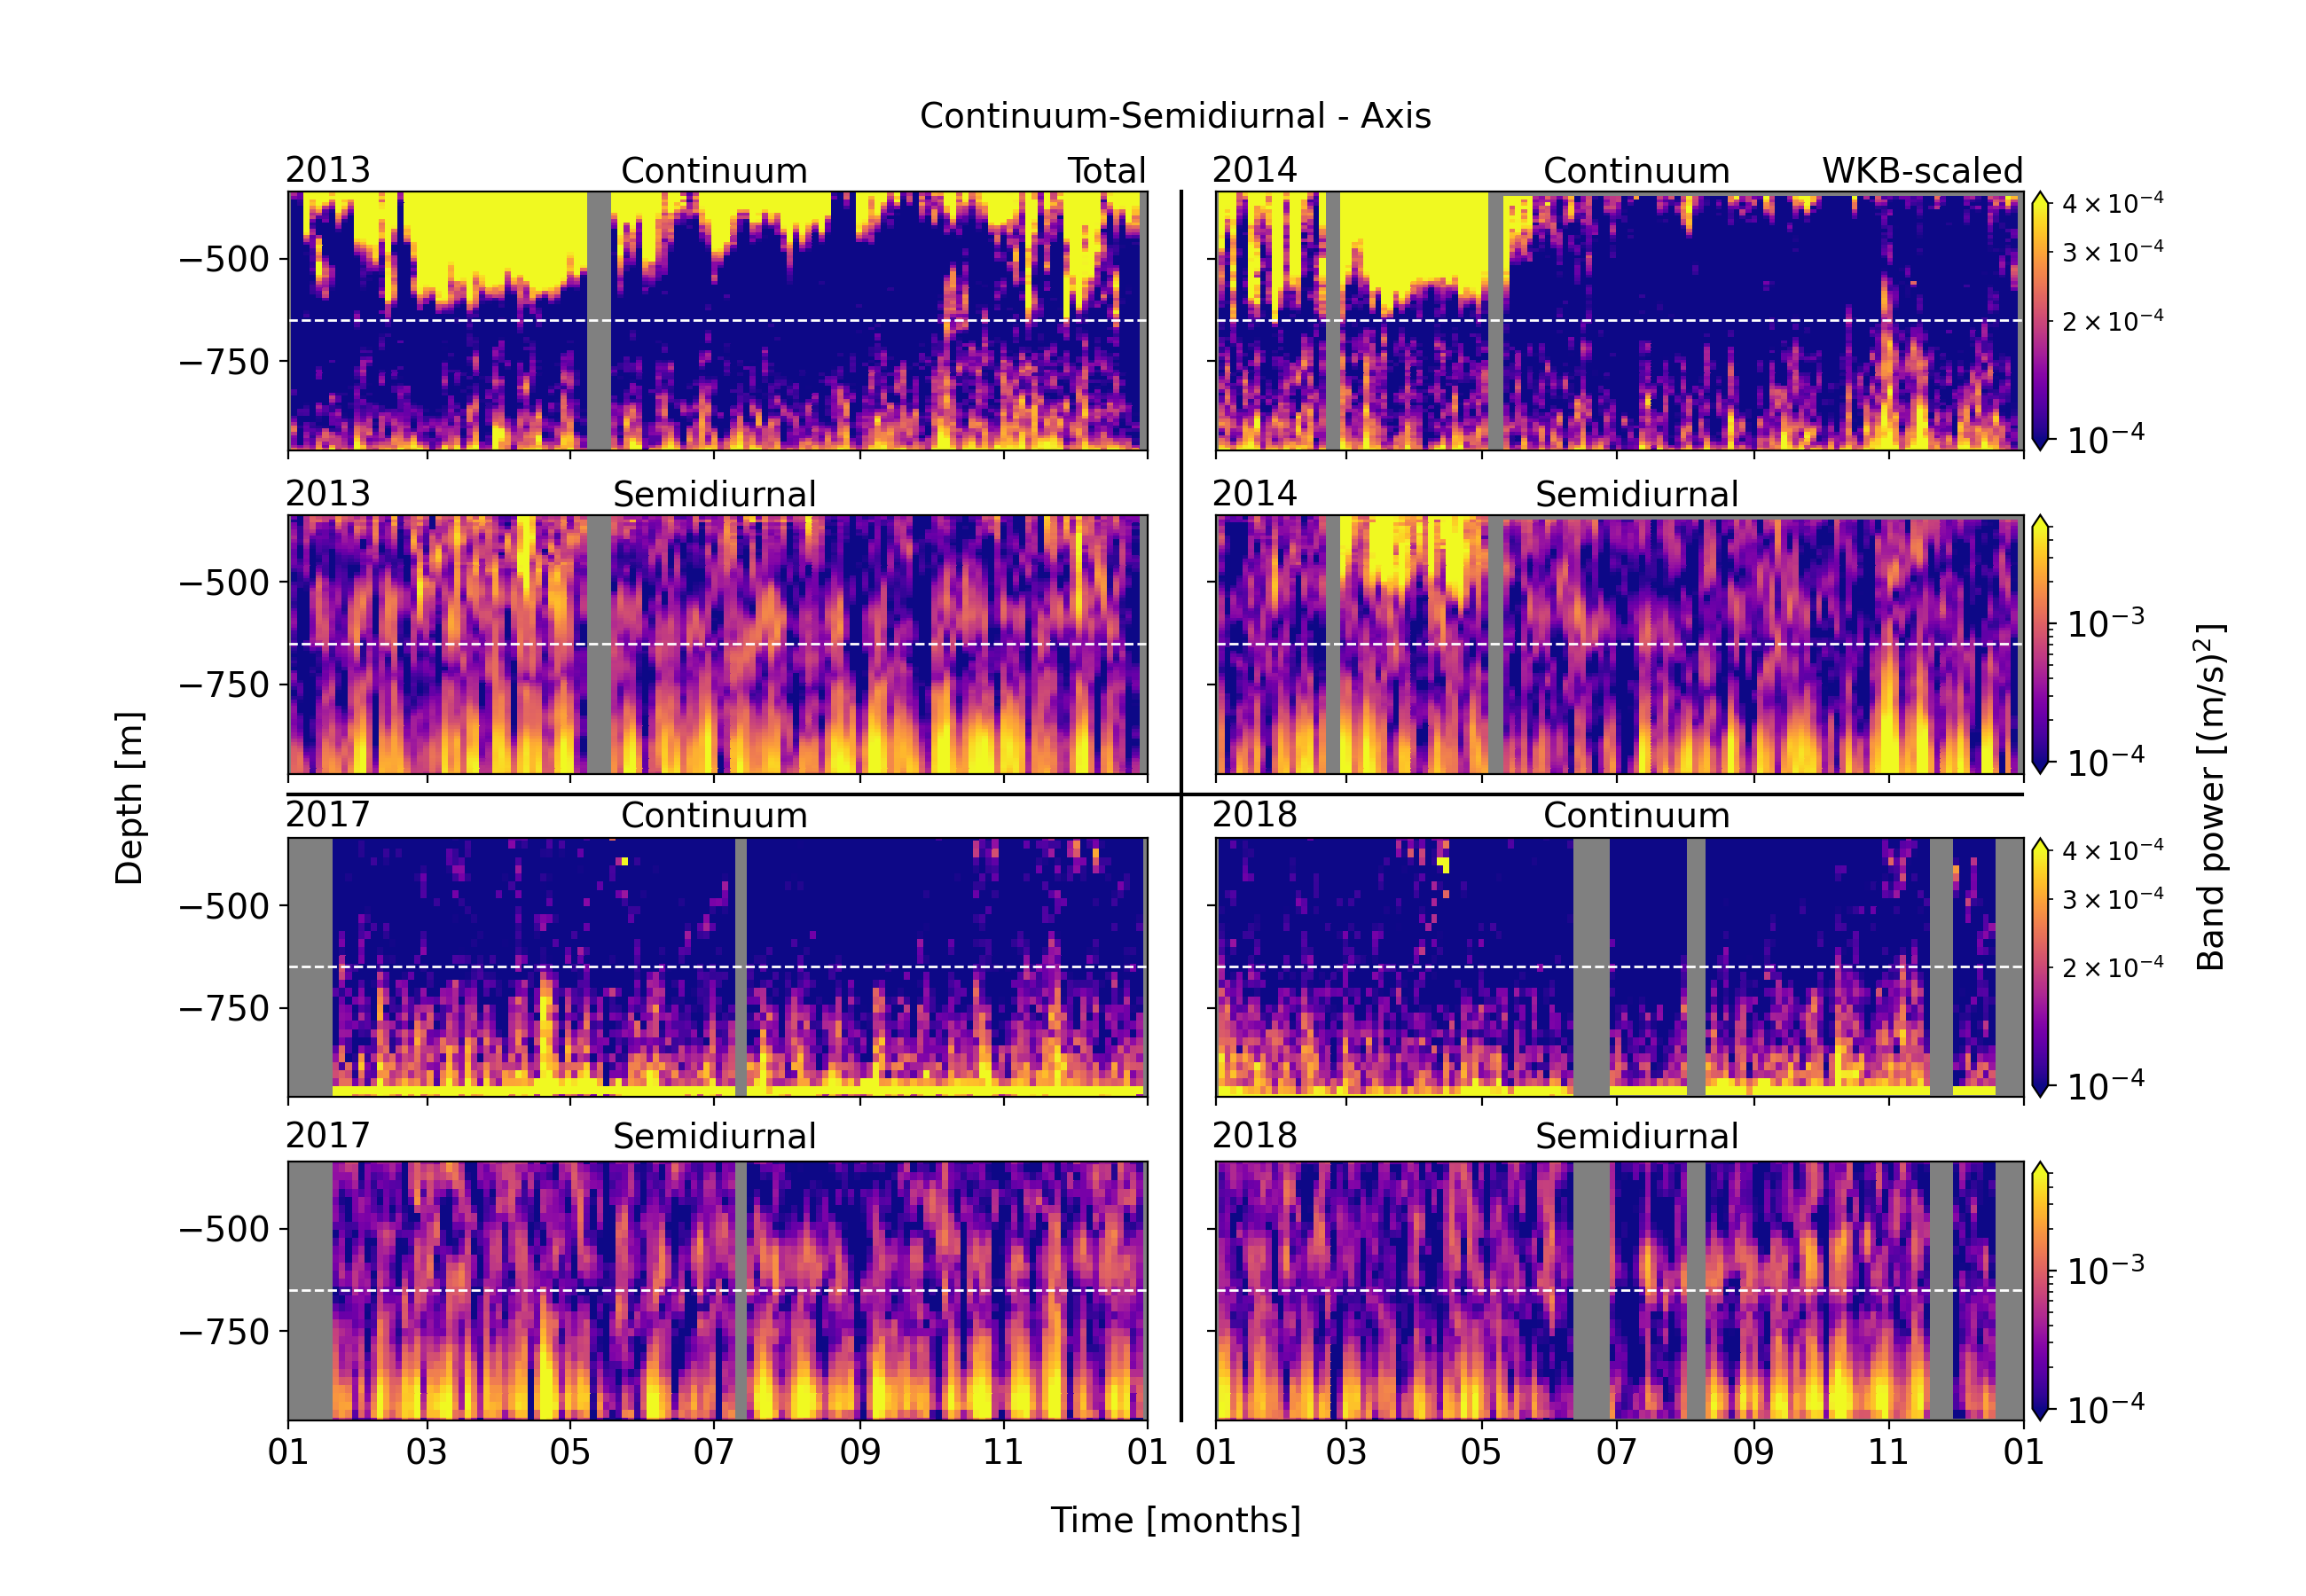

In [102]:
# plot comparison data

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
fig.subplots_adjust(hspace = 0.25)

fig.text(0.51, 0.92, f'Continuum-{band2} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.544, 0.886, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2013', ha='center',fontsize=14)
fig.text(0.544, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.544, 0.482, '2018', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2017', ha='center',fontsize=14)
fig.text(0.544, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Continuum':  
    fig.text(0.31, 0.886, 'Continuum', ha='center', fontsize=14)
    fig.text(0.71, 0.886, 'Continuum', ha='center', fontsize=14)
    fig.text(0.31, 0.482, 'Continuum', ha='center', fontsize=14)
    fig.text(0.71, 0.482, 'Continuum', ha='center', fontsize=14)
    fig.text(0.48, 0.886, 'Total', ha='center', fontsize=14)
    if site == 'Axis':
        vmin = 1e-4
        vmax = 4e-4
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
 
if band2 == 'Diurnal':
    fig.text(0.31, 0.683, 'Diurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.683, 'Diurnal', ha='center', fontsize=14)
    fig.text(0.31, 0.281, 'Diurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.281, 'Diurnal', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 3e-5
        vmax2 = 5e-3
    elif site == 'Slope':
        vmin2 = 3e-5
        vmax2 = 5e-4
elif band2 == 'Inertial':  
    fig.text(0.31, 0.683, 'Inertial', ha='center', fontsize=14)
    fig.text(0.71, 0.683, 'Inertial', ha='center', fontsize=14)
    fig.text(0.31, 0.281, 'Inertial', ha='center', fontsize=14)
    fig.text(0.71, 0.281, 'Inertial', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 6e-5
        vmax2 = 5e-3
    elif site == 'Slope':
        vmin2 = 6e-5
        vmax2 = 5e-3
elif band2 == 'Semidiurnal':  
    fig.text(0.31, 0.683, 'Semidiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.683, 'Semidiurnal', ha='center', fontsize=14)
    fig.text(0.31, 0.281, 'Semidiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.281, 'Semidiurnal', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 1e-4
        vmax2 = 5e-3
    elif site == 'Slope':
        vmin2 = 6e-5
        vmax2 = 3e-3
elif band2 == 'Subdiurnal':  
    fig.text(0.31, 0.683, 'Subdiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.683, 'Subdiurnal', ha='center', fontsize=14)
    fig.text(0.31, 0.281, 'Subdiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.281, 'Subdiurnal', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 1e-4
        vmax2 = 5e-3
        #fig.text(0.71, 0.886, 'Subdiurnal', ha='center', fontsize=14)
        #fig.text(0.544, 0.886, 'Total', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin2 = 1e-4
        vmax2 = 5e-3
        #fig.text(0.544, 0.886, 'Total', ha='center', fontsize=14)

date_form = pldates.DateFormatter("%m")

years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax0.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax4.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax5.xaxis.set_major_formatter(date_form)

years2 = [ds2_2013,ds2_2014,ds2_2017,ds2_2018] 
for k,i in enumerate(years2):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax2.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax6.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax7.xaxis.set_major_formatter(date_form)
            
            
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax2]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax1,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax6]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax5,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

fig.add_artist(lines.Line2D([0.5125, 0.5125], [0.11, 0.88],color='black'))
fig.add_artist(lines.Line2D([0.125, 0.877], [0.5025, 0.5025],color='black'))    
    
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_cascade_{band2}_{site}.pdf',format='pdf')